#  Logistic Regression and Classification Error Metrics

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [3]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['/Users/Samuel/Desktop/Development/Git_Hub/TP_Regressao_Logistica-pt2/CI_Logistic_Regression-pt2']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [4]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [5]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [6]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [7]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [8]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [9]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

6859    1
8649    3
5737    1
6       2
3119    1
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [11]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

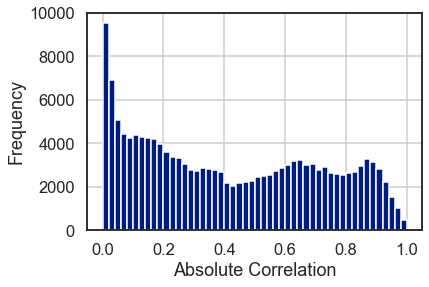

In [13]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [14]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']


In [16]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [17]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [40]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(max_iter=500, penalty='none').fit(X_train, y_train)
lr.coef_

array([[-1.12753241e+02,  2.17473305e+01,  2.45980653e+01, ...,
         9.53565032e+02, -3.76644087e+02, -6.82954926e+01],
       [-3.63002811e+02, -1.45168850e+02,  4.20596431e+01, ...,
        -9.63621538e+01, -1.91236271e+02, -1.29107255e+02],
       [ 1.68917715e+02,  1.10952883e+02,  1.22638853e+02, ...,
        -4.20272436e+02,  3.28980342e+02,  1.70286659e+01],
       [-8.56589782e+00, -2.41487603e+01,  3.06382555e+00, ...,
        -1.76212251e+02,  1.14312819e+01,  8.12989496e+01],
       [ 2.30427066e+02,  5.25608146e+01,  3.51594570e-01, ...,
        -3.66623233e+02, -3.00660366e+01, -1.88568620e+01],
       [ 8.49771695e+01, -1.59434179e+01, -1.92711982e+02, ...,
         1.05905042e+02,  2.57534771e+02,  1.17931994e+02]])

In [41]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [18]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations

In [42]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train, y_train)

### Breve explicação:

Foram expostos os coeficientes de cada regressão logistica com o seus respectivos algoritmos de solução. Houve uma demora considerável com o uso do algoritmo 'liblinear', isso se dá pelo fato que o algoritmo 'liblinear' usar o método de resolução 'um por todos' (onde cada conjunto de dados de uma classe é comparada com o conjunto de dados das outras restantes) esse, é mais viável para um conjunto de dados menor. Esses algoritmos de otimização possuem a vantagem de não precisarem do alfa, como no calculo do gradiente, entretanto com a desvantagem de serem mais complexos.

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [43]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

#for lab,mod in zip(coeff_labels, coeff_models):
#    coeffs = mod.coef_
#    levels=[[lab], [0,1,2,3,4,5]]
#    labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]]
#    coeff_label = pd.MultiIndex(levels,labels)
#    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)



lr                                                              \
              0           1           2           3           4           5   
53   369.004587  355.411038 -490.287188   -3.814828   71.833492 -302.147101   
261    6.942482  313.722959 -347.027388 -381.632597  106.923941  301.070603   
297   -7.756099   43.596381  131.900491 -457.443176  290.107713   -0.405310   
287 -196.671734 -935.437809  336.180668  213.060274  272.542685  310.325917   
543  -56.309810 -179.710467  143.619304  158.206799   36.582278 -102.388104   
133   27.667912  114.786380  -69.156190  213.702936  -87.201654 -199.799385   
103 -229.840036 -359.641118 -173.478573  426.191975  -19.524992  356.292745   
386  -27.564302  -13.826213   62.074199 -168.223314  161.677876  -14.138246   
345 -129.385645  -49.182547 -178.648621  196.376800  103.149201   57.690812   
551  -40.403788 -517.622860  483.631999 -215.339468  227.399340   62.334778   

           l1                                                          l2  \
            0         1         2         3         4         5         0   
53   2.496678  2.223411 -7.898005  0.000000  0.622741 -2.616203  1.055034   
261  0.000000  0.000000 -0.222772 -1.653122  0.000000  1.095166  0.087409   
297 -0.289943  0.000000 -0.188704 -0.745022  1.436648  0.713906  0.040655   
287  0.000000 -2.031971  2.259060  1.128161  0.000000  1.940932 -0.111111   
543  0.000000  0.000000  0.000000  0.000000  0.000000 -0.567439 -0.028056   
133  0.016074  0.000000  0.000000  0.339761  0.000000 -1.349550 -0.011825   
103 -0.147953  0.000000 -0.077264  2.005559 -0.225038  1.138560 -0.188034   
386 -0.014714  0.000000  0.000000  0.000000  0.516616 -0.015078 -0.018107   
345 -0.047275  0.000000  0.000000  0.771540  0.000000 -0.718610 -0.061878   
551 -0.200695 -0.096111  0.715143  0.000000  2.444513 -0.259372  0.000610   

                                                       
            1         2         3         4         5  
53   1.458397 -2.515385  0.165345  0.371030 -0.534422  
261  0.227701 -0.257415 -0.578712  0.066272  0.454745  
297  0.141364 -0.162024 -0.860263  0.544118  0.296151  
287 -1.545404  1.077032  0.116238  0.112864  0.350381  
543 -0.350524  0.317056  0.254160  0.041023 -0.233659  
133  0.119302 -0.002638  0.534630 -0.137859 -0.501610  
103 -0.107272 -0.240620  0.608127 -0.421220  0.349019  
386 -0.058801  0.018575 -0.287449  0.302910  0.042872  
345 -0.036381 -0.187808  0.368279  0.006011 -0.088222  
551 -0.389630  0.280674 -0.207645  0.369342 -0.053352

### Breve explicação:

Como sabemos, quando utilizamos a regressão logística para rótulos multiclasse, o modelo encontrará um conjunto de coeficientes para cada classe, devido ao "método um vs resto". Assim, cada modelo contém 6 conjuntos de coeficientes que diferem uns dos outros.

Prepare six separate plots for each of the multi-class coefficients.

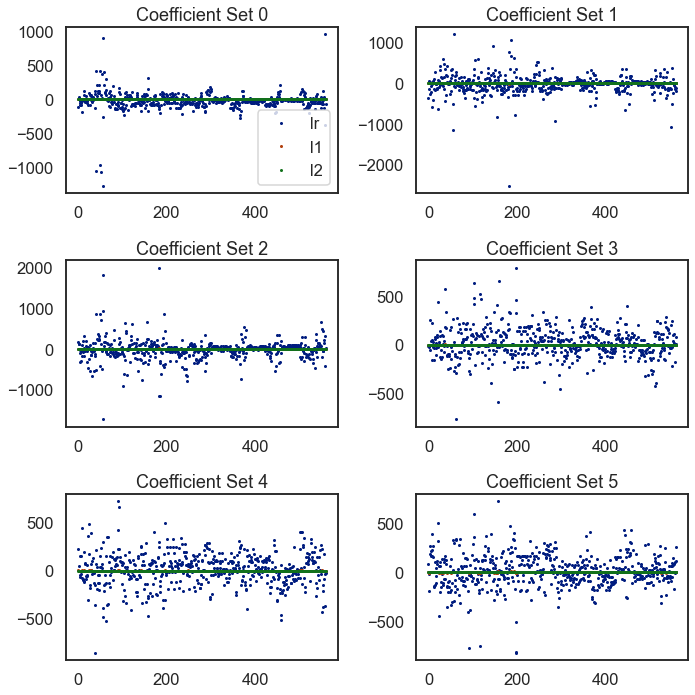

In [44]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data_aux = coefficients.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()




### Breve explicação:

Nas imagens acime, foi representado graficamente os conjuntos de coeficientes obtidos para a primeira classe com a rotulação por cor nos 3 modelos, em seguida, aplicou-se o mesmo para a segunda classe e sucessivamente.

## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [45]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()



,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [46]:
y_prob.head()

,lr,l1,l2
0,1.0,0.998952,0.999998
1,1.0,0.999577,0.999656
2,1.0,0.995683,0.998874
3,1.0,0.999171,0.997831
4,1.0,0.999922,0.999304


### Breve explicação:

Acima, está sendo exibido duas tabelas que mostram a regressão e a probabilidade para cada curva.

## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [47]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [48]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.980888,0.983833,0.983485
recall,0.980906,0.983819,0.983495
fscore,0.980884,0.983817,0.983488
accuracy,0.980906,0.983819,0.983495
auc,0.988437,0.990148,0.989983


### Breve explicação:

Na tabela acima, não vemos uma diferença estatisticamente significativa nas métricas de erro entre os 3 modelos, mesmo usando apenas o primeiro (sem regularização) podemos esperar um ótimo desempenho na previsão das atividades.

## Question 8

Display or plot the confusion matrix for each model.

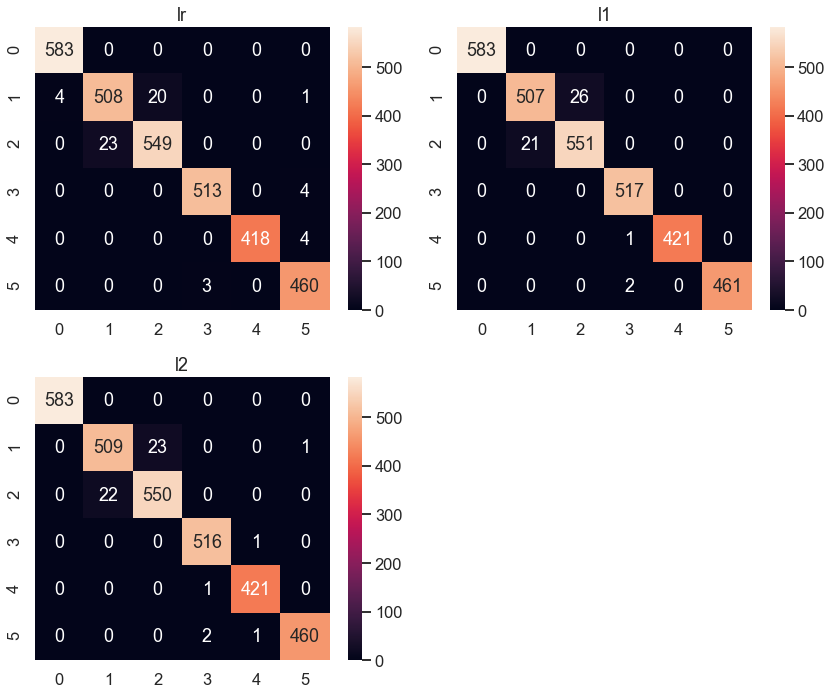

In [49]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


### 

## Question 9
 Identify highly correlated columns and drop those columns before building models

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold


X_data = data.iloc[:, :-1]


#threshold with .7
sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
X_data = pd.DataFrame(sel.fit_transform(X_data))


feature_cols = X_data.columns[:]


# Dividindo os subjconjuntos de treino e teste, seguindo os mesmos
# Indices obtidos com Stratified Shuffle Split, agora com os dados
# Com menos features
 

X_train_new = X_data.loc[train_idx, :]

y_train_new = data.loc[train_idx, 'Activity']
 
X_test_new  = X_data.loc[test_idx, :]
y_test_new  = data.loc[test_idx, 'Activity']
 
print(X_train.shape)
print(X_train_new.shape)
 
print(X_test.shape)
print(X_test_new.shape)

(7209, 561)
(7209, 50)
(3090, 561)
(3090, 50)


 Repeat Model building with new training data after removing higly correlated columns

In [56]:
# Try standard, L1 and L2 Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# Foi necessário aumentar o número de interações em todas as regressões.

# Standard logistic regression
lr_new = LogisticRegression(max_iter=10000, penalty='none').fit(X_train_new, y_train_new)


In [27]:
# L1 regularized logistic regression
lr_l1_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear', max_iter=10000).fit(X_train_new, y_train_new)


In [ ]:
# L2 regularized logistic regression
lr_l2_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train_new, y_train_new)

In [31]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations


## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [63]:
# Combine all the coefficients into a dataframe for comparison
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr_new, lr_l1_new, lr_l2_new]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                           \
            0          1          2           3          4           5   
31  -4.525759   2.288616  -5.559621   -0.132872   8.997210   -1.067574   
5  -21.691896  61.074182 -50.279692 -157.542540   9.788312  158.651633   
36 -13.184974 -12.669919   9.852855   13.238213   2.223496    0.540330   
8  -31.300302 -44.217095  49.533659   84.414942  -5.499734  -52.931472   
4  -10.254826 -11.353099  -9.957370   15.183023   3.908932   12.473340   
9    0.690716  -4.281817  -3.567028    2.583389   2.311390    2.263351   
6  -11.392740  22.176306  -9.183024  -87.208930  50.208222   35.400165   
34  -4.346637  -2.906370  -2.265775    1.955144   6.482496    1.081143   
24   2.998528   0.688753   0.083007    5.065953  -4.715257   -4.120984   
13  -5.527292  -8.291256  -9.269856   12.847093   0.807058    9.434253   

          l1                                                               l2  \
           0          1          2          3         4          5          0   
31  0.000000   0.000000  -3.996344   0.245854  9.618817  -2.946078  -0.291727   
5  -4.504890  47.195116  10.703891  -0.717727 -7.006353  16.190574 -11.557402   
36  0.000000  -3.642969  -9.175240   7.913533 -5.469707 -15.179158  -2.234414   
8  -3.433385 -49.942344  34.601539   7.098126 -3.390308  -6.114625  -6.604074   
4   0.000000  -0.578453   1.983699   3.234838 -7.283950   3.776751  -2.753281   
9   0.557621  -0.752985   0.724435  -0.094601  0.046468   0.254976   0.281784   
6   0.000000   9.726760   2.162077 -60.824613 -1.578810   3.332729  -9.175751   
34  0.000000   0.000000   1.852822   1.084165  3.465585   0.399178  -1.675139   
24  0.000000  -0.628874   0.902119  10.103023 -1.078524  -0.660639   1.441810   
13  0.000000   0.048472  -0.685384   4.785818 -6.170784   2.385170  -1.770805   

                                                           
            1          2          3          4          5  
31  -1.338769  -1.479542  -0.382544   6.178327  -2.685745  
5   34.062858 -26.713081 -22.381400  -2.976976  29.566001  
36 -12.064256   8.133703   8.961266  -0.492423  -2.303876  
8  -39.833602  36.084057  25.895643  -5.931246  -9.610777  
4   -6.863567  -5.413357   9.104101  -1.311513   7.237616  
9   -1.929775  -1.206405   1.102058   0.924394   0.827943  
6   22.336239 -12.199107 -77.923869  43.187150  33.775337  
34  -1.667642  -0.904415   0.212905   4.646978  -0.612688  
24  -0.350738   0.753836   4.041010  -3.166508  -2.719410  
13  -4.388288  -5.629515   8.997775  -2.785315   5.576149

Prepare six separate plots for each of the multi-class coefficients.

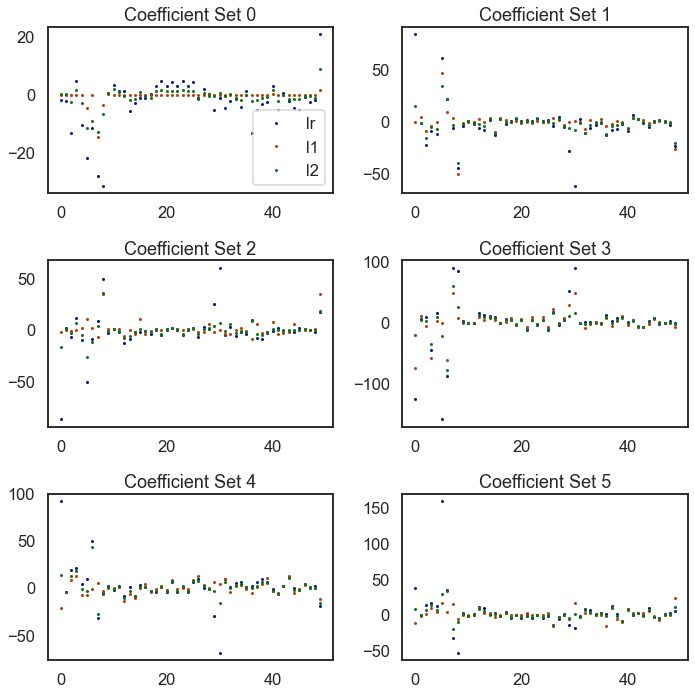

In [64]:
# try the plots

fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [65]:
# Predict the class and the probability for each
y_pred_new = list()
y_prob_new = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr_new, lr_l1_new, lr_l2_new]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred_new.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob_new.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))
    
y_pred_new = pd.concat(y_pred_new, axis=1)
y_prob_new = pd.concat(y_prob_new, axis=1)

y_pred_new.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [66]:
# Calculate the error metrics as listed above
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test_new, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test_new, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test_new, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test_new, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [67]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.980888,0.983833,0.983485
recall,0.980906,0.983819,0.983495
fscore,0.980884,0.983817,0.983488
accuracy,0.980906,0.983819,0.983495
auc,0.988437,0.990148,0.989983


## Question 13

Display or plot the confusion matrix for each model.

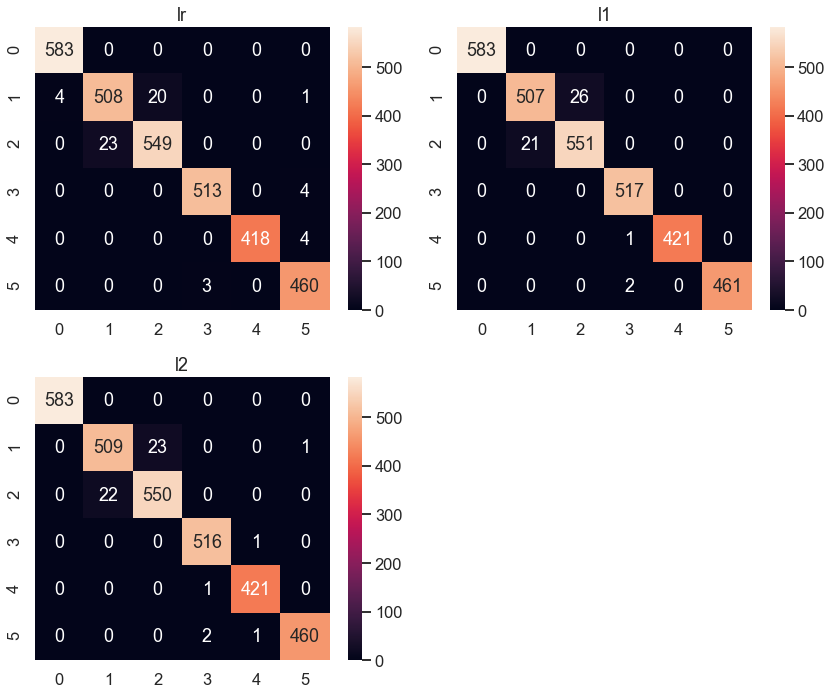

In [68]:
#plot the confusion matrix
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

In [36]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation

In [37]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation